# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1]:
!pip install livelossplot

In [1]:
import pandas as pd
import string
import nltk 
from gensim.models import Word2Vec
import re
import numpy as np
from livelossplot import PlotLosses
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
pd.set_option('display.width', -1)
pd.set_option('max_colwidth', -1)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
lyrics_df = pd.read_csv("/content/drive/My Drive/lyrics.csv", usecols=['genre', 'lyrics'])
lyrics_df.sample(2)

,genre,lyrics
123403,Rock,NaN
278329,Metal,"""Vuelvo A Ser Mortal (AntihÃ©roe)""\nEn la oscuridad y la soledad,\nDe esta frÃ­a habitaciÃ³n.\nPuedo respirar,\nVer la realidad,\nEncontrarme con mi voz.\nSin el antifaz,\nVuelvo a ser mortal,\nTan sencillo como tÃº.\nNo es mÃ¡s que un disfraz,\nPara ocultar\nUna esencia a contraluz.\nSi estas conmigo...\nSÃ¡lvame de la tormenta,\nDe mis dudas,\nMi torpeza.\nVen, quÃ©date aquÃ­.\nSÃ¡lvame de mis flaquezas,\nDel dolor,\nDe la tristeza.\nVen, ven a por mÃ­.\nSiempre quise ser\nTodo lo que ves,\nMostrarme como soy.\nAunque aprendÃ­\nA sobrevivir,\nEl silencio se quedÃ³.\nVuelvo a despertar\nCuando la ciudad\nSe oculta frente a mÃ­.\nY mis sueÃ±os son\nSolo una ilusiÃ³n\nTan difÃ­cil de cumplir.\nTe necesito...\nSÃ¡lvame de la tormenta,\nDe mis dudas,\nMi torpeza.\nVen, quÃ©date aquÃ­.\nSÃ¡lvame de mis flaquezas,\nDel dolor,\nDe la tristeza.\nVen, ven a por mÃ­.\nSin el antifaz,\nVuelvo a ser mortal\nConvirtiÃ©ndome en un antihÃ©roe.\nSÃ¡lvame de la tormenta,\nDe mis dudas,\nMi torpeza.\nVen, quÃ©date aquÃ­.\nSÃ¡lvame de mis flaquezas,\nDel dolor,\nDe la tristeza.\nVen, ven a por mÃ­."


In [0]:
lyrics_df = lyrics_df.where((pd.notnull(lyrics_df)), None)

In [6]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 2 columns):
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: object(2)
memory usage: 5.5+ MB


In [0]:
lyrics_df = lyrics_df[lyrics_df['lyrics'].notnull()]

In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
def cleanText(text):
  text = text.lower()
  text = re.sub(r'\d', '#', text) 
  text = re.sub(r"\s+"," ", text, flags = re.I)
  tokens = tokenizer.tokenize(text.lower())
  tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
  
  return tokens if len(tokens) > 0 else None

In [0]:
lyrics_df['clean_lyrics'] = lyrics_df['lyrics'].apply(cleanText)

In [0]:
lyrics_df = lyrics_df[lyrics_df['clean_lyrics'].notnull()]

In [12]:
lyrics_df[['genre', 'clean_lyrics']].sample(3)

,genre,clean_lyrics
116195,Rock,"[virginia, kind, anyway, desire, virginia, crucified, dying, keeps, alive, swell, made, everyone, else, happy, horribly, well, girl, soul, shelf, virginia, knows, bleed, giving, never, comes, free, virginia, desperately, wanting, whole, world, watching, misery, swell, made, everyone, else, happy, horribly, well]"
127112,Hip-Hop,"[turn, head, phones, comin, ghetto, near, street, fame, haha, comin, ghetto, near, mad, tricks, shot, time, sanitize, posse, look, paranoid, niggas, got, cellular, calls, traced, since, surveillance, silently, momma, chill, thug, livin, pay, bills, die, violently, closed, caskets, expose, bastards, leave, em, bloody, deloris, tucker, let, kids, hear, nigga, speak, gettin, money, nothin, funny, green, got, nigga, seein, things, hit, lye, hope, god, fly, lethal, weapon, savage, still, method, madness, blast, niggas, laugh, call, em, care, cabbage, read, em, weep, put, em, sleep, hell, bound, lyrics, leave, em, spell, bound, clown, tired, bein, held, cross, heart, hope, die, blinded, pussy, ...]"
88157,Rock,"[chorus, like, prisoner, know, right, wrong, like, baby, sings, pleading, song, many, tears, must, fall, yes, many, tears, must, fall, like, sailor, steers, away, home, feels, tidal, wave, heart, alone, chorus, like, prisoner, know, right, wrong, like, baby, sing, pleading, song, never, know, feel, yes, never, know, feel]"


In [0]:
FEATURE_VECTOR_SIZE = 300 
WINDOW_SIZE = 5
all_sentenses = lyrics_df["clean_lyrics"].tolist()
wevec_model = Word2Vec(all_sentenses, size=FEATURE_VECTOR_SIZE, window=WINDOW_SIZE, workers=4, min_count=3)

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [0]:
for word in ['love', 'man', 'girl', 'feel']:
  print('**********{}**************'.format(word))
  print(wevec_model.wv.most_similar('love'))
  print('**********{}**************'.format(word))
  

**********love**************
[('know', 0.6976536512374878), ('baby', 0.6739638447761536), ('cause', 0.6532072424888611), ('true', 0.620837926864624), ('oh', 0.6157742738723755), ('want', 0.6149493455886841), ('never', 0.6118445992469788), ('always', 0.6080036163330078), ('heart', 0.6009585857391357), ('way', 0.5991636514663696)]
**********love**************
**********man**************
[('know', 0.6976536512374878), ('baby', 0.6739638447761536), ('cause', 0.6532072424888611), ('true', 0.620837926864624), ('oh', 0.6157742738723755), ('want', 0.6149493455886841), ('never', 0.6118445992469788), ('always', 0.6080036163330078), ('heart', 0.6009585857391357), ('way', 0.5991636514663696)]
**********man**************
**********girl**************
[('know', 0.6976536512374878), ('baby', 0.6739638447761536), ('cause', 0.6532072424888611), ('true', 0.620837926864624), ('oh', 0.6157742738723755), ('want', 0.6149493455886841), ('never', 0.6118445992469788), ('always', 0.6080036163330078), ('heart', 0

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [0]:
v1 = wevec_model.wv['king'] 
v2 = wevec_model.wv['queen'] 

res =  v1 - v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('king', 0.4416906237602234),
 ('victorious', 0.28422659635543823),
 ('christ', 0.28422001004219055),
 ('overthrow', 0.2781832814216614),
 ('disarmament', 0.2606436610221863),
 ('undisputed', 0.2583610415458679),
 ('overcome', 0.25667399168014526),
 ('solomon', 0.2539622485637665),
 ('dispear', 0.24596869945526123),
 ('battle', 0.23669087886810303)]

In [0]:
v1 = wevec_model.wv['woman'] 
v2 = wevec_model.wv['girl'] 

res =  v1 - v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.3945504426956177),
 ('witchy', 0.3829672932624817),
 ('adherence', 0.3591882586479187),
 ('hath', 0.355106920003891),
 ('wastelands', 0.35092365741729736),
 ('hinguckt', 0.3403870761394501),
 ('wanhopige', 0.3390408158302307),
 ('incarnate', 0.33836591243743896),
 ('parachutist', 0.3364051580429077),
 ('dissatisfied', 0.3338039517402649)]

In [0]:
v1 = wevec_model.wv['girl'] 
v2 = wevec_model.wv['man'] 

res =  v1 + v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('girl', 0.8658943176269531),
 ('man', 0.8452440500259399),
 ('woman', 0.7247971892356873),
 ('boy', 0.7180936336517334),
 ('know', 0.6527124047279358),
 ('baby', 0.6476815938949585),
 ('cause', 0.638348400592804),
 ('got', 0.6022270321846008),
 ('yeah', 0.5943912267684937),
 ('love', 0.5738491415977478)]

In [0]:
v1 = wevec_model.wv['woman'] 
v2 = wevec_model.wv['husband'] 

res =  v1 + v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.8930797576904297),
 ('husband', 0.7790439128875732),
 ('wife', 0.6306020021438599),
 ('man', 0.6067594289779663),
 ('girl', 0.5493606328964233),
 ('daughter', 0.5384731292724609),
 ('child', 0.49661391973495483),
 ('women', 0.48693349957466125),
 ('neighbor', 0.46220311522483826),
 ('lovin', 0.4582667052745819)]

In [0]:
v1 = wevec_model.wv['wife'] 
v2 = wevec_model.wv['woman'] 

res =  v1 - v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wife', 0.5940633416175842),
 ('doorjust', 0.39944425225257874),
 ('beaters', 0.38050615787506104),
 ('tillman', 0.3772699236869812),
 ('nephews', 0.3584328591823578),
 ('ahhhhaaaaaaaaghhhh', 0.3539944887161255),
 ('attended', 0.34795355796813965),
 ('swipe', 0.33600378036499023),
 ('saver', 0.3341713845729828),
 ('burglary', 0.32993119955062866)]

In [0]:
v1 = wevec_model.wv['young'] 
v2 = wevec_model.wv['baby'] 

res =  v1 + v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('young', 0.7975558042526245),
 ('baby', 0.7816184163093567),
 ('girl', 0.6593176126480103),
 ('love', 0.6478465795516968),
 ('cause', 0.6436699628829956),
 ('know', 0.6418748497962952),
 ('yeah', 0.6136243343353271),
 ('boy', 0.6044150590896606),
 ('got', 0.5908496975898743),
 ('want', 0.58655846118927)]

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [14]:
twitter_lex_df = pd.read_csv('/content/drive/My Drive/SemEval2015-English-Twitter-Lexicon.txt', sep='\t',  names =['polarity', 'word'])
twitter_lex_df.describe(include = 'all')

,polarity,word
count,1515.000000,1515
unique,NaN,1515
top,NaN,#phenomenal
freq,NaN,1
mean,0.000319,NaN
std,0.502247,NaN
min,-0.984000,NaN
25%,-0.422000,NaN
50%,0.031000,NaN
75%,0.406000,NaN


In [0]:
twitter_lex_df.sample(3)

,polarity,word
382,0.391,no rush
584,0.188,read
390,0.391,proper


In [0]:
twitter_lex_df['vector'] = twitter_lex_df["word"].apply(lambda word: wevec_model.wv[word].reshape(1,-1) if word in wevec_model.wv else None)
twitter_lex_df = twitter_lex_df[twitter_lex_df.vector.notnull()]


In [0]:
  
train, test = train_test_split(twitter_lex_df, test_size=0.2, random_state=999)
X_train = train['vector'].values
y_train = train['polarity'].values
X_test = test['vector'].values
y_test = test['polarity'].values

X_train = np.concatenate(X_train).reshape(X_train.shape[0], X_train[0].shape[1])

shape = list(X_test[0].shape)
X_test = np.concatenate(X_test).reshape(X_test.shape[0],X_test[0].shape[1])

In [0]:
model = XGBRegressor()
model.fit(X_train, y_train)

[15:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
model.score(X_test, y_test)

0.35175120519967285

In [19]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [0]:
import torch.utils.data as utils_data
from torch.autograd import Variable

training_samples = utils_data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
data_loader = utils_data.DataLoader(training_samples, batch_size=5, shuffle=False)	

test_samples = utils_data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_data_loader = utils_data.DataLoader(test_samples, batch_size=len(X_test), shuffle=False)	
test_data_loader_1 = utils_data.DataLoader(test_samples, batch_size=1, shuffle=False)


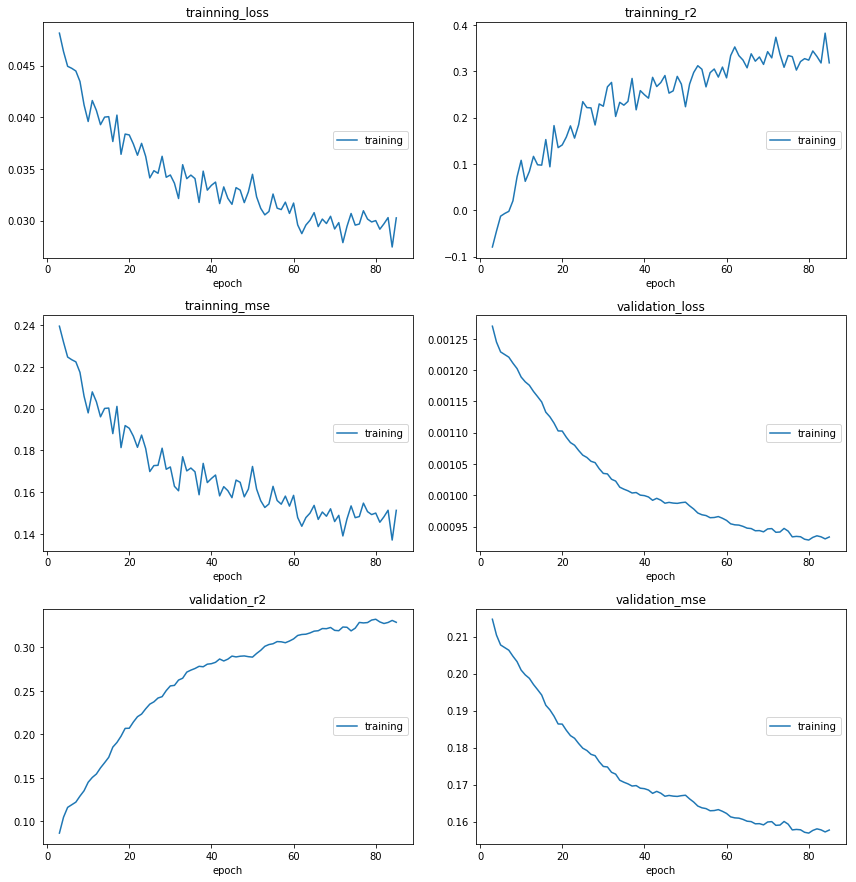

trainning_loss:
training   (min:    0.027, max:    0.064, cur:    0.030)

trainning_r2:
training   (min:   -0.445, max:    0.382, cur:    0.318)

trainning_mse:
training   (min:    0.137, max:    0.321, cur:    0.151)

validation_loss:
training   (min:    0.001, max:    0.001, cur:    0.001)

validation_r2:
training   (min:    0.001, max:    0.332, cur:    0.329)

validation_mse:
training   (min:    0.157, max:    0.235, cur:    0.158)


In [0]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from sklearn.metrics import r2_score, mean_squared_error


def score(netModel, data_loader, criterion):
  
  running_loss = 0.
  calc_count =0.
  valTrue  = []
  valPredicted  = []
  
  netModel.eval()
  
  with torch.no_grad():
    for vectors, labels in data_loader:
      if use_cuda:
        vectors = vectors.cuda()
        labels = labels.cuda().float()
        
      vectors = Variable(vectors)  
      labels = Variable(labels)
      
      outputs = netModel(vectors.float())
      
      valPredicted.extend(outputs.detach().cpu().numpy().flatten())
      valTrue.extend(labels.detach().cpu().numpy().flatten())
      
      loss = criterion(outputs.flatten(), labels.flatten())
      running_loss += loss.item()
      
  return running_loss/len(valTrue), r2_score(valTrue, valPredicted), mean_squared_error(valTrue, valPredicted)


liveloss = PlotLosses()

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.hidden(x))   
        x = self.dropout2(x)
        x = self.predict(x)  
        return x

      
      
net = Net(n_feature=300, n_hidden=20, n_output=1)     
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()

if use_cuda:
  net = net.cuda()
  
# plt.ion()  

for epoch in range(1000):
  
  net.train()
  
  batchloss = 0.0
  yTrue = []
  YPredicted = []
  for batch_idx, (data, target) in enumerate(data_loader):
        
    if use_cuda:
      data = data.cuda()
      target = target.cuda()
          
          
    data, target = Variable(data).float(), Variable(target).float()
    optimizer.zero_grad()
    prediction = net(data)
    loss = loss_func(prediction.flatten(), target.flatten()) 
    
    
    YPredicted.extend(prediction.detach().cpu().numpy().flatten())
    yTrue.extend(target.detach().cpu().numpy().flatten())
        
    loss.backward() 
    optimizer.step()
    
    batchloss += loss.item()
  
  losLog = {}
  losLog['trainning_loss'] = batchloss/len(YPredicted)
  
  r2 = r2_score(yTrue, YPredicted)
  losLog['trainning_r2'] = r2
  trainningMSE = mean_squared_error(yTrue, YPredicted)
  losLog['trainning_mse'] = trainningMSE
  
  valLoss, valR2, valMSE = score(net, test_data_loader, loss_func )
  
  losLog['validation_loss'] = valLoss
  losLog['validation_r2'] = valR2
  losLog['validation_mse'] = valMSE
  liveloss.update(losLog)
  liveloss.draw()
        

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

Show the confusion matrix.

Show the classification report - precision, recall, f1 for each class.

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.